In [1]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.4 MB 23 kB/s 
     |████████████████████████████████| 199 kB 62.6 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845512 sha256=f3f0781178946be008d39d7d803097b521d016ae9e3665421bdc5d1c72a2b867
  Stored in directory: /root/.cache/pip/wheels/43/dc/11/ec201cd671da62fa9c5cc77078235e40722170ceba231d7598
Successfully built pyspark


In [2]:
!pip install pyspark
!pip install findspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import pyspark

In [4]:
from pyspark.sql import SparkSession

In [5]:
spark = SparkSession.builder.appName('data_603_project').getOrCreate()

In [6]:
spark

In [7]:
!pip install -q handyspark

In [8]:
import findspark
findspark.init
from pyspark.sql import SparkSession
import pyspark.sql.functions as f
from pyspark.sql.types import StructType,StringType,IntegerType,MapType,ArrayType,StructField
from pyspark.sql.functions import count,when,col,isnan,from_json,explode,map_keys,udf,coalesce,lit,to_date,year,split,get_json_object,array,collect_list,concat_ws,regexp_replace,regexp_extract
from pyspark.sql.functions import row_number,lit
from pyspark.sql.window import Window
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.ticker import FuncFormatter
import plotly.graph_objects as go
import plotly.express as px
from wordcloud import WordCloud
import os

**Extract Transform Load Process**

In [9]:
links=spark.read\
.format("com.databricks.spark.csv")\
.option("multiline",True)\
.option("header",True)\
.option("escape", "\"")\
.option("inferschema",True)\
.csv("./links.csv")
keywords=spark.read\
.format("com.databricks.spark.csv")\
.option("multiline",True)\
.option("header",True)\
.option("escape", "\"")\
.option("inferschema",True)\
.csv("./keywords.csv")
movies_metadata=spark.read\
.format("com.databricks.spark.csv")\
.option("multiline",True)\
.option("header",True)\
.option("escape", "\"")\
.option("inferschema",True)\
.csv("./movies_metadata.csv")
credits=spark.read\
.format("com.databricks.spark.csv")\
.option("multiline",True)\
.option("header",True)\
.option("escape", "\"")\
.option("inferschema",True)\
.csv("./credits.csv")
ratings=spark.read\
.format("com.databricks.spark.csv")\
.option("multiline",True)\
.option("header",True)\
.option("escape", "\"")\
.option("inferschema",True)\
.csv("./ratings.csv")

In [10]:
credits.printSchema()

root
 |-- cast: string (nullable = true)
 |-- crew: string (nullable = true)
 |-- id: integer (nullable = true)



In [11]:
keywords.printSchema()

root
 |-- id: integer (nullable = true)
 |-- keywords: string (nullable = true)



In [12]:
links.printSchema()

root
 |-- movieId: integer (nullable = true)
 |-- imdbId: integer (nullable = true)
 |-- tmdbId: integer (nullable = true)



In [13]:
movies_metadata.printSchema()

root
 |-- adult: string (nullable = true)
 |-- belongs_to_collection: string (nullable = true)
 |-- budget: string (nullable = true)
 |-- genres: string (nullable = true)
 |-- homepage: string (nullable = true)
 |-- id: string (nullable = true)
 |-- imdb_id: string (nullable = true)
 |-- original_language: string (nullable = true)
 |-- original_title: string (nullable = true)
 |-- overview: string (nullable = true)
 |-- popularity: string (nullable = true)
 |-- poster_path: string (nullable = true)
 |-- production_companies: string (nullable = true)
 |-- production_countries: string (nullable = true)
 |-- release_date: string (nullable = true)
 |-- revenue: long (nullable = true)
 |-- runtime: double (nullable = true)
 |-- spoken_languages: string (nullable = true)
 |-- status: string (nullable = true)
 |-- tagline: string (nullable = true)
 |-- title: string (nullable = true)
 |-- video: boolean (nullable = true)
 |-- vote_average: double (nullable = true)
 |-- vote_count: integer (nu

In [14]:
ratings.printSchema()

root
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- rating: double (nullable = true)
 |-- timestamp: integer (nullable = true)



**Metadata review and data cleansing**

In [15]:
schema=StructType().add("fileName",StringType(),nullable=True).add("fileCount",IntegerType(),nullable=True).add('noOfColumns',IntegerType(),nullable=True)

dataDictionary=[('Credits.csv',credits.count(),len(credits.columns)),('Keywords.csv',keywords.count(),len(keywords.columns))
,('links.csv',links.count(),len(links.columns)),('Movies_metadata.csv',movies_metadata.count(),len(movies_metadata.columns)),
('Ratings.csv',ratings.count(),len(ratings.columns))]

df = spark.createDataFrame(data=dataDictionary, schema =schema )
df.show()

+-------------------+---------+-----------+
|           fileName|fileCount|noOfColumns|
+-------------------+---------+-----------+
|        Credits.csv|    45476|          3|
|       Keywords.csv|    46419|          2|
|          links.csv|    45843|          3|
|Movies_metadata.csv|    45466|         24|
|        Ratings.csv| 26024289|          4|
+-------------------+---------+-----------+



**Null values handling**

In [16]:
movies_metadata=movies_metadata.where(~col('id').isin('82663','162372','215848'))# drop few corrupted
#records

#drop rows which have null values in the Json column - "production_companies","production_countries"
movies_metadata=movies_metadata.na.drop(subset=["production_companies","production_countries","genres"])

Columns 'production_countries','production_companies','genres' have Json format data. There are many rows where these columns value is '[]'. We will replace '[]' to 'Unknwon' to avoid any Json parsing issues.

In [17]:
movies_metadata=movies_metadata.withColumn('genres',when(col('genres')=='[]',"[{'id': 0, 'name': 'Unknown'}]").otherwise(col('genres')))\
               .withColumn('production_companies',when(col('production_companies')=='[]',"[{'name': 'Unknown', 'id': 0}]").otherwise(col('production_companies')))\
               .withColumn('production_countries',when(col('production_countries')=='[]',"[{'iso_3166_1': 'Unknown', 'name': 'Unknown'}]").otherwise(col('production_countries')))

**Null count check**

In [18]:
datadict={'Ratings.csv':ratings,'Movies_metadata.csv':movies_metadata,'Credits.csv':credits,'Keywords.csv':keywords,'links.csv':links}

for key,value in datadict.items() :
  dfStats= value.select([count(when(col(c).isNull()|isnan(c),'True')).alias(c) for c,c_type in value.dtypes if c_type not in ('timestamp','boolean')])
  print("Column stats for data file :" +key+"\n")
  dfStats.show()

Column stats for data file :Ratings.csv

+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|     0|      0|     0|        0|
+------+-------+------+---------+

Column stats for data file :Movies_metadata.csv

+-----+---------------------+------+------+--------+---+-------+-----------------+--------------+--------+----------+-----------+--------------------+--------------------+------------+-------+-------+----------------+------+-------+-----+------------+----------+
|adult|belongs_to_collection|budget|genres|homepage| id|imdb_id|original_language|original_title|overview|popularity|poster_path|production_companies|production_countries|release_date|revenue|runtime|spoken_languages|status|tagline|title|vote_average|vote_count|
+-----+---------------------+------+------+--------+---+-------+-----------------+--------------+--------+----------+-----------+--------------------+--------------------+------------+-------+-------+-------------

In [19]:
#Change Column data type
movies_metadata=movies_metadata.withColumn('budget',col('budget').cast('integer'))\
                               .withColumn('popularity',col('popularity').cast('float'))\
                               .withColumn('revenue',col('revenue').cast('integer'))

**Drop duplicate rows**

In [20]:
df_dup=movies_metadata.groupby('imdb_id','title','release_date', 'overview').count().filter("count > 1").show()

+---------+--------------------+------------+--------------------+-----+
|  imdb_id|               title|release_date|            overview|count|
+---------+--------------------+------------+--------------------+-----+
|tt0454792|              Bubble|  2005-09-03|Set against the b...|    2|
|tt0287635|Pokémon 4Ever: Ce...|  2001-07-06|All your favorite...|    2|
|tt1821641|        The Congress|  2013-05-16|More than two dec...|    2|
|tt0270288|Confessions of a ...|  2002-12-30|Television made h...|    2|
|tt1180333|            Blackout|  2008-12-26|Recovering from a...|    3|
|tt0022537|          The Viking|  1931-06-21|Originally called...|    2|
|tt1701210|          Black Gold|  2011-12-21|On the Arabian Pe...|    2|
|tt0499456|    Days of Darkness|  2007-01-01|When a comet stri...|    2|
|tt0084387|Nana, the True Ke...|  1983-06-13|In Zola's Paris, ...|    2|
|tt0157472|       Clockstoppers|  2002-03-17|Until now, Zak Gi...|    2|
|tt2121382|       Force Majeure|  2014-08-15|While 

In [21]:
movies_metadata.groupby('imdb_id','title','release_date', 'overview').count().where(f.col('count')>1).select(f.sum('count')).show()

+----------+
|sum(count)|
+----------+
|        59|
+----------+



In [22]:
# DROP Duplicates - using drop_duplicates - RETURNS NEW DF
movies_metadata=movies_metadata.drop_duplicates(['imdb_id','title','release_date', 'overview'])

**EDA**

**movies_metadata - Json field parsing**

In [23]:
movies_metadata.toPandas().head(10)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,None,0.0,"[{'id': 0, 'name': 'Unknown'}]",None,45514,None,en,8,8 shorts centered around 8 themes directed by ...,...,2008-10-23,0.0,100.0,"[{'iso_639_1': 'fr', 'name': 'Français'}, {'is...",Rumored,None,8,False,0.0,0.0
1,False,None,1000000.0,"[{'id': 80, 'name': 'Crime'}]",None,36337,None,en,Delusion,"In this fast-paced, noirish road movie, a comp...",...,1991-06-07,0.0,100.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,She only wanted love. But money's better than ...,Delusion,False,4.8,3.0
2,False,None,0.0,"[{'id': 0, 'name': 'Unknown'}]",None,161535,None,en,Doraemon:貓狗時空傳,"One day, Nobita finds a stray dog drowning in ...",...,2004-03-06,0.0,0.0,[],Released,None,Doraemon:貓狗時空傳,False,0.0,0.0
3,False,None,2500000.0,"[{'id': 9648, 'name': 'Mystery'}, {'id': 53, '...",http://www.delawarepictures.net/dreamkiller/,36663,None,en,Dreamkiller,"A team of doctors experiment with a new, highl...",...,None,0.0,110.0,[],Released,Fear is the greatest killer.,Dreamkiller,False,5.0,1.0
4,False,None,0.0,"[{'id': 0, 'name': 'Unknown'}]",None,118013,None,en,Endeavour,Shaun Evans (The Take) steps into John Thaw's ...,...,None,0.0,98.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Rookie detective Endeavor Morse faces his firs...,Endeavour,False,6.6,19.0
5,False,None,0.0,"[{'id': 14, 'name': 'Fantasy'}, {'id': 12, 'na...",None,65256,None,en,H2O Just Add Water - The Movie,When three normal teenage girls stumble upon a...,...,2011-10-10,0.0,91.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Do you believe in mermaids?,H2O Just Add Water - The Movie,False,6.4,37.0
6,False,"{'id': 75014, 'name': 'How I Unleashed World W...",0.0,"[{'id': 10769, 'name': 'Foreign'}, {'id': 28, ...",None,75015,None,pl,Jak rozpętałem drugą wojnę światową: Cz.3 - Wś...,How I Unleashed World War II tells the story o...,...,1970-04-06,0.0,73.0,"[{'iso_639_1': 'de', 'name': 'Deutsch'}, {'iso...",Released,None,How I Unleashed World War II Part III: Among F...,False,7.0,3.0
7,False,None,0.0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",None,430514,None,fr,Le passe-muraille,None,...,2016-12-16,0.0,NaN,"[{'iso_639_1': 'fr', 'name': 'Français'}]",Released,None,Le passe-muraille,False,0.0,0.0
8,False,None,0.0,"[{'id': 12, 'name': 'Adventure'}, {'id': 18, '...",None,293412,None,en,Running Wild,Jennifer Barker plays a troubled woman who has...,...,1995-01-01,0.0,0.0,[],Released,None,Running Wild,False,10.0,1.0
9,False,None,0.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 16, 'nam...",None,88013,tt0000003,fr,Pauvre Pierrot,"One night, Arlequin come to see his lover Colo...",...,1892-10-28,0.0,4.0,"[{'iso_639_1': 'xx', 'name': 'No Language'}]",Released,None,Poor Pierrot,False,6.1,19.0


In [24]:
movies_metadata=movies_metadata.withColumnRenamed("id","id_ori")\
                                .withColumnRenamed("poster_path","poster_path_ori")

#Attach schema to Json object column
df=movies_metadata.withColumn("belongs_to_collection_value",from_json(movies_metadata.belongs_to_collection,MapType(StringType(),StringType())))
                  

# Get the distinct Keys of Json object
key_df=df.select(explode(map_keys(col('belongs_to_collection_value')))).distinct()

# Convert Key collection object to a List
keylst=list(map(lambda row:row[0],key_df.collect()))

#Retrive values based on Keys into a seperate column
key_cols=map(lambda f:df['belongs_to_collection_value'].getItem(f).alias(str(f)),keylst)
#df2=df2.select(col('belongs_to_collection'),*key_cols)
df=df.select(*movies_metadata.columns,*key_cols)
df.printSchema()

root
 |-- adult: string (nullable = true)
 |-- belongs_to_collection: string (nullable = true)
 |-- budget: integer (nullable = true)
 |-- genres: string (nullable = true)
 |-- homepage: string (nullable = true)
 |-- id_ori: string (nullable = true)
 |-- imdb_id: string (nullable = true)
 |-- original_language: string (nullable = true)
 |-- original_title: string (nullable = true)
 |-- overview: string (nullable = true)
 |-- popularity: float (nullable = true)
 |-- poster_path_ori: string (nullable = true)
 |-- production_companies: string (nullable = true)
 |-- production_countries: string (nullable = true)
 |-- release_date: string (nullable = true)
 |-- revenue: integer (nullable = true)
 |-- runtime: double (nullable = true)
 |-- spoken_languages: string (nullable = true)
 |-- status: string (nullable = true)
 |-- tagline: string (nullable = true)
 |-- title: string (nullable = true)
 |-- video: boolean (nullable = true)
 |-- vote_average: double (nullable = true)
 |-- vote_count: 

**Json column parsing - production_companies , production_countries , genres**

In [25]:
schema = ArrayType(StructType([
        StructField('id', IntegerType(), nullable=False), 
        StructField('name', StringType(), nullable=False)]))

#Step 2 - UDF function to convert list to column seperated values. As Data is in Json array, extracting 
#values based on Json keys will  produce list
convertUDF = udf(lambda s: ','.join(map(str, s)),StringType())

#Step 3 - Json parsing
df=df.withColumn("production_companies_values",when(col('production_companies')=='[]','').otherwise(convertUDF(from_json(movies_metadata.production_companies,schema).getField("name"))))\
     .withColumn("production_countries_values",convertUDF(from_json(movies_metadata.production_countries,schema).getField("name")))\
     .withColumn("genres_value",convertUDF(from_json(movies_metadata.genres,schema).getField("name")))

df.select('id_ori',"genres_value","production_companies_values","production_countries_values").show(10,False)

+------+-----------------------------+---------------------------------------------------+---------------------------+
|id_ori|genres_value                 |production_companies_values                        |production_countries_values|
+------+-----------------------------+---------------------------------------------------+---------------------------+
|45514 |Unknown                      |Unknown                                            |France                     |
|36337 |Crime                        |Cineville                                          |United States of America   |
|161535|Unknown                      |Unknown                                            |Unknown                    |
|36663 |Mystery,Thriller             |Unknown                                            |Unknown                    |
|118013|Unknown                      |Unknown                                            |Unknown                    |
|65256 |Fantasy,Adventure            |ZDF Enterp

**Summary Statistics**

In [26]:
df.select('runtime','budget','revenue','vote_average','vote_count','popularity')\
  .summary("count", "min", "25%", "75%", "max").show()

+-------+-------+---------+-----------+------------+----------+----------+
|summary|runtime|   budget|    revenue|vote_average|vote_count|popularity|
+-------+-------+---------+-----------+------------+----------+----------+
|  count|  45171|    45428|      45428|       45428|     45428|     45428|
|    min|    0.0|        0|-1507002209|         0.0|         0|       0.0|
|    25%|   85.0|        0|          0|         5.0|         3|  0.385836|
|    75%|  107.0|        0|          0|         6.8|        34|  3.676626|
|    max| 1256.0|380000000| 2068223624|        10.0|     14075|  547.4883|
+-------+-------+---------+-----------+------------+----------+----------+



In [27]:
df_pd=df.select("runtime","revenue","vote_average","vote_count").toPandas()


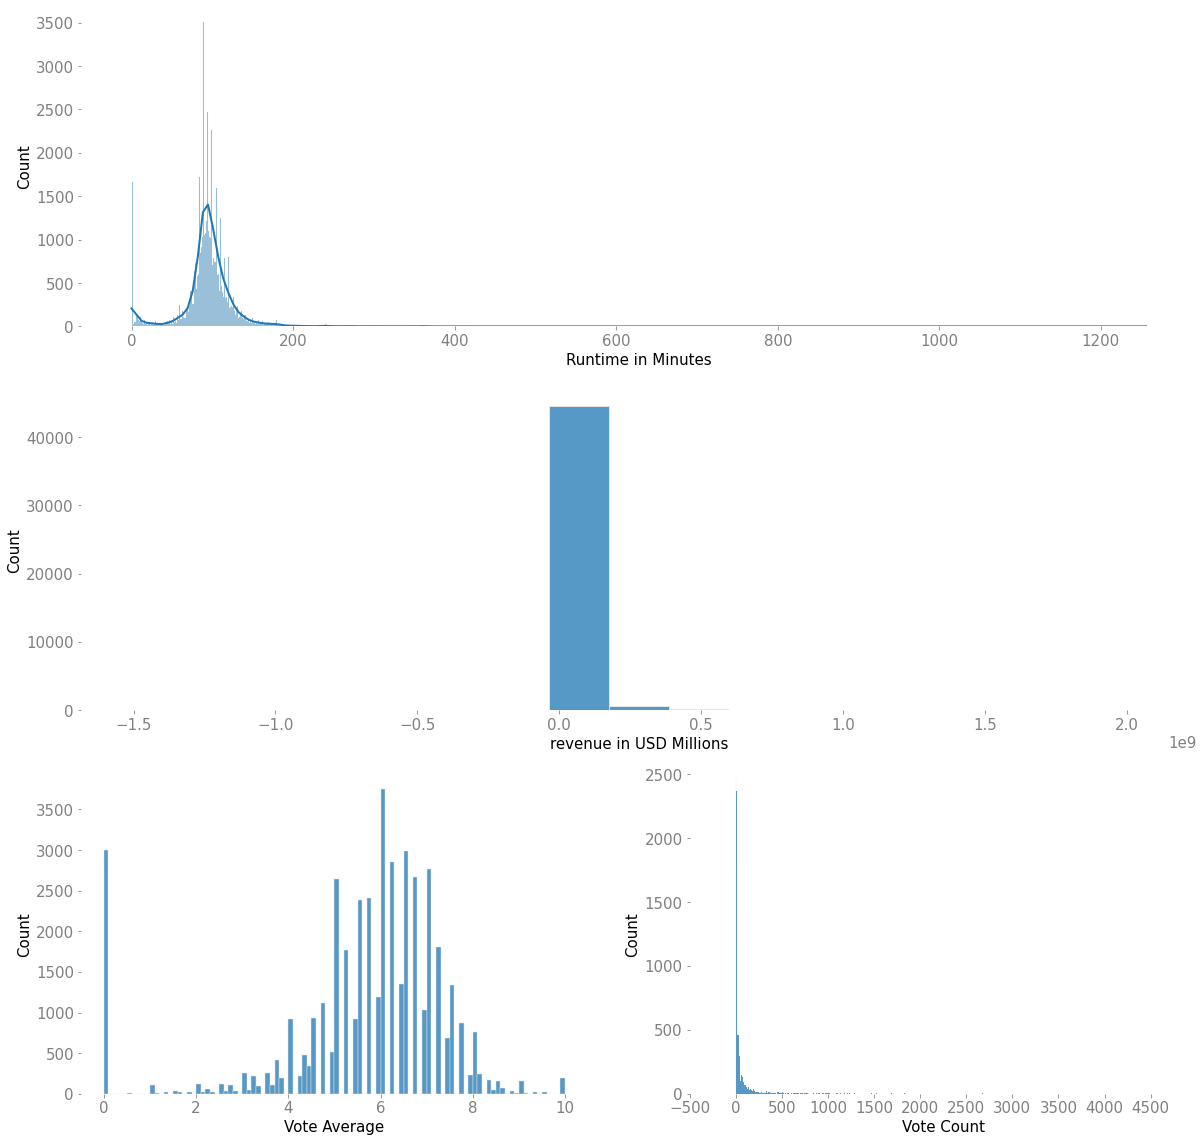

In [28]:
from matplotlib import cycler

colors = cycler('color',
                ['#EE6666', '#3388BB', '#9988DD',
                 '#EECC55', '#88BB44', '#FFBBBB'])
plt.rc('axes', facecolor='#ffffff', edgecolor='none',
       axisbelow=True, grid=True)
plt.rc('grid', color='w', linestyle='solid')

plt.rc('xtick', direction='out', color='gray')
plt.rc('ytick', direction='out', color='gray')
plt.rc('patch', edgecolor='#E6E6E6')
plt.rc('lines', linewidth=2)
plt.rc(('xtick', 'ytick'), labelsize=15)
plt.rcParams['axes.labelsize'] = 15


fig = plt.figure(figsize=(20,20))
grid = plt.GridSpec(3, 2, wspace=0.2, hspace=0.2)


f1=sns.histplot(data=df_pd ,x="runtime", kde=True,ax=fig.add_subplot(grid[0, :]))
f1.set_xlabel('Runtime in Minutes')

f2=sns.histplot(data=df_pd ,x="revenue", kde=False,ax=fig.add_subplot(grid[1,:]))
f2.set_xlabel('revenue in USD Millions')

f3=sns.histplot(data=df_pd ,x="vote_average", kde=False,ax=fig.add_subplot(grid[2,:1]))
f3.set_xlabel('Vote Average')

f3=sns.histplot(data=df_pd ,x="vote_count", kde=False,ax=fig.add_subplot(grid[2,1]))
f3.set_xlabel('Vote Count')
f3.set_xlim(0,5000)
f3.xaxis.set_ticks(np.arange(-500, 5000, 500))
f3.set_ylim(0,2500)

plt.show()

**Profit/loss correlation with other attributes**

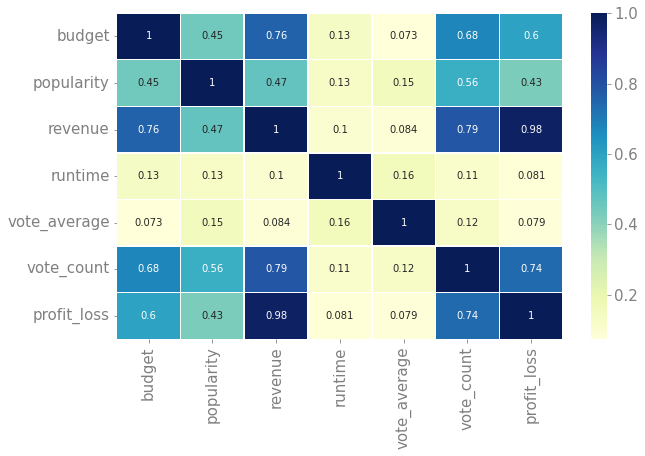

In [29]:
data_for_corr=df.select('budget','popularity','revenue','runtime','vote_average','vote_count')\
                              .withColumn("profit_loss",coalesce(col('revenue'),lit(0))-coalesce(col('budget'),lit(0)))

data_for_corr_pd=data_for_corr.toPandas().dropna(how='any')# convert to Pandas dataframe and rows which has null values

data_for_corr_pd.to_csv('Corelation_Data.csv')




correlations = data_for_corr_pd.corr()
f,ax = plt.subplots(figsize=(10,6))
sns.heatmap(correlations, annot=True, cmap="YlGnBu", linewidths=.5)

plt.show()

**Top 10 voted movies**

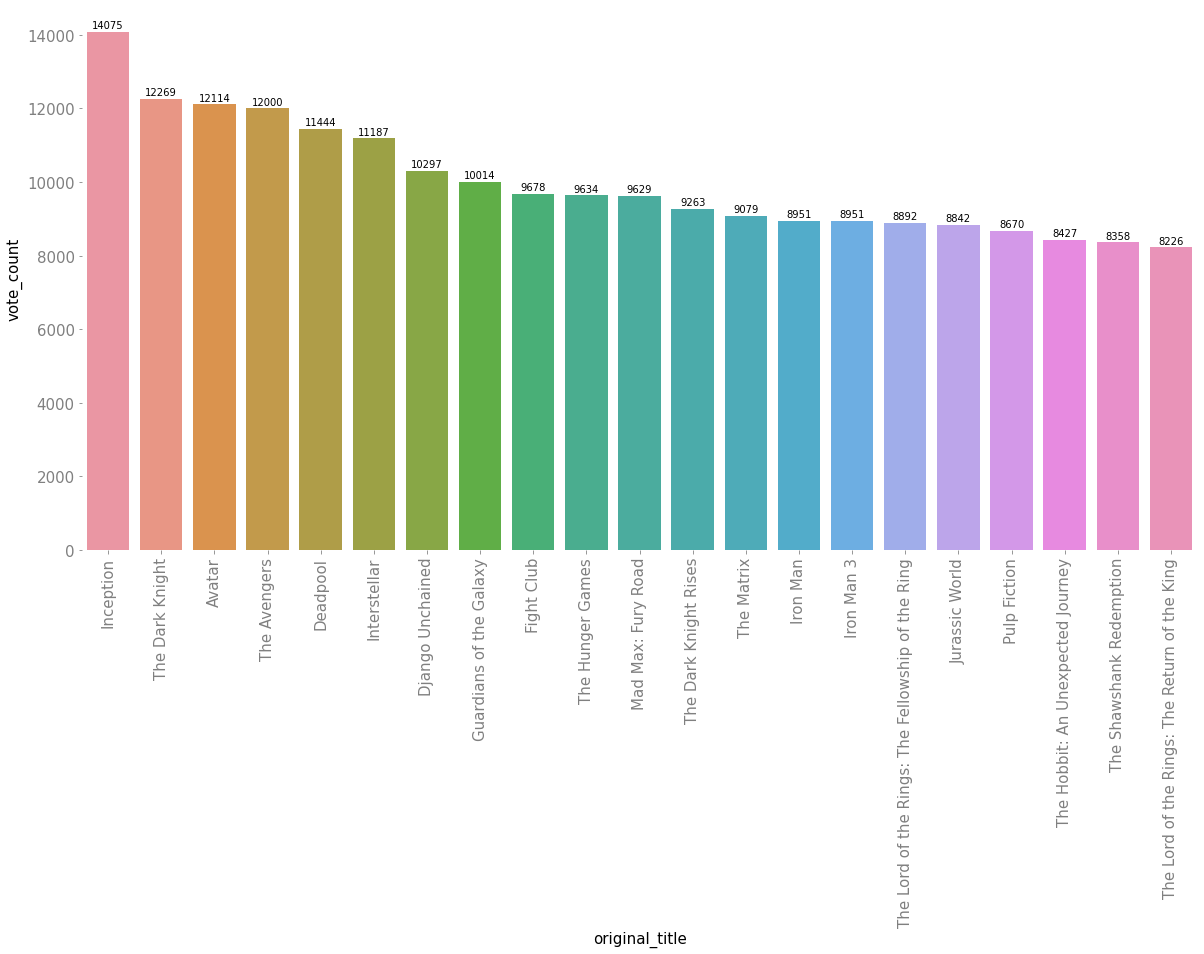

In [30]:
df_pd_votecount=df.select('original_title','vote_count','vote_average').toPandas()
df_pd_votecount=df_pd_votecount.sort_values(by='vote_count',ascending=False).iloc[0:21,:].reset_index(drop=True)

df_pd_votecount.to_csv('Votescount.csv')

fig = plt.figure(figsize=(20,10))
ax=plt.subplot(111)
bar_plot=sns.barplot(x=df_pd_votecount['original_title'],y=df_pd_votecount['vote_count'],ax=ax)
for tick in bar_plot.get_xticklabels():
    tick.set_rotation(90)


def _show_on_single_plot(ax):        
        for p in bar_plot.patches:
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height()+100
            value =format(int(p.get_height()))
            ax.text(_x, _y, value, ha="center") 


_show_on_single_plot(bar_plot)
plt.show()

**Top 10 movies by budget vs revenue**

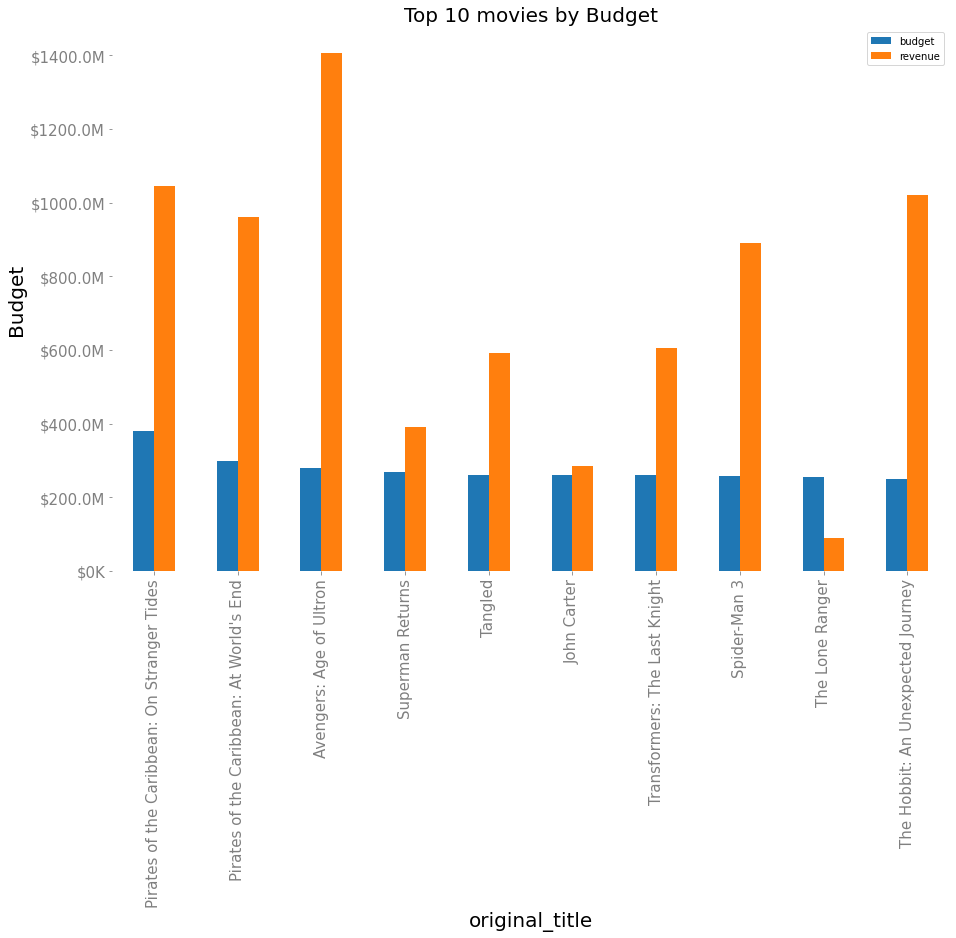

In [31]:
df_moviesBybudget=df.select('id_ori','original_title','budget','revenue').orderBy(col('budget'),ascending=False)

#convert to Pandas dataframe
df_pd_top15moviesBybudget=df_moviesBybudget.toPandas().head(10)

df_pd_top15moviesBybudget.to_csv('Top_10_movies_budget.csv')

def currency(x, pos):
    'The two args are the value and tick position'
    if x >= 1000000:
        return '${:1.1f}M'.format(x*1e-6)
    return '${:1.0f}K'.format(x*1e-3)



ax=df_pd_top15moviesBybudget.plot(x="original_title", y=["budget","revenue"],kind="bar",figsize=(15, 10))
formatter = FuncFormatter(currency)
ax.yaxis.set_major_formatter(formatter)
ax.set_xlabel('original_title',fontsize=20)
ax.set_ylabel('Budget',fontsize=20)
ax.set_title('Top 10 movies by Budget',fontsize=20, loc='center')
plt.show()

**Top 10 movies by Revenue**

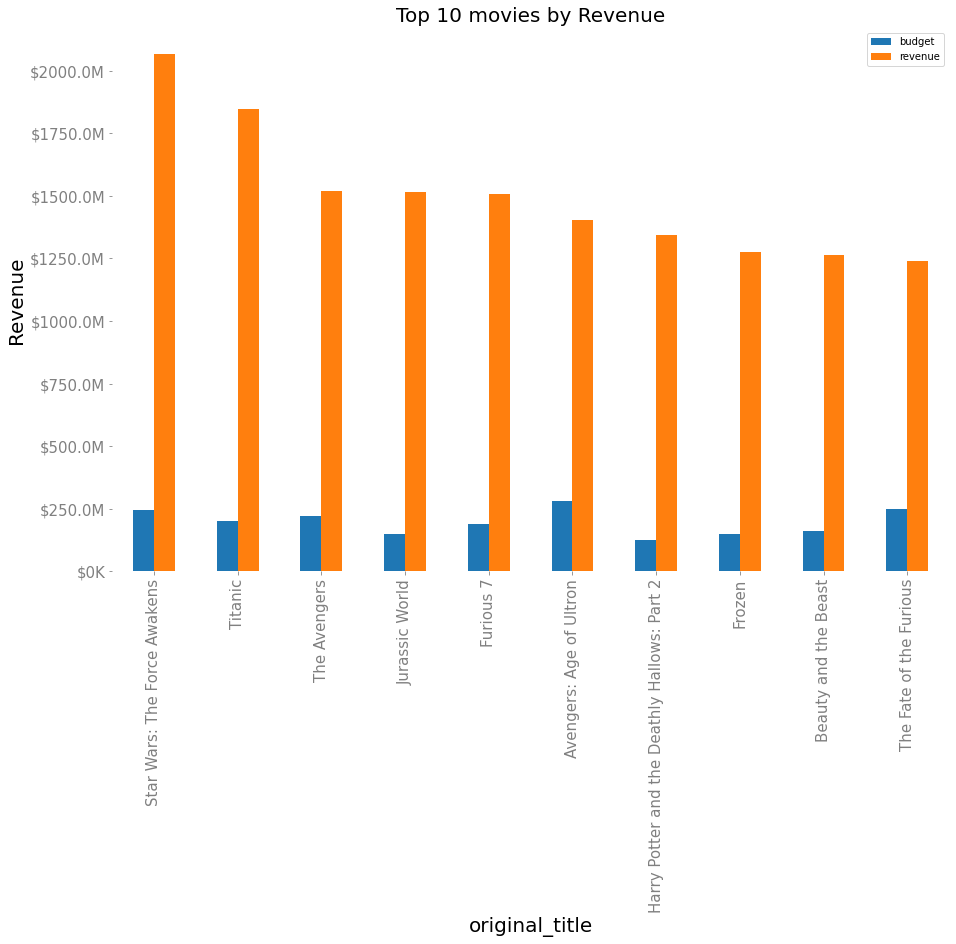

In [32]:
df_moviesByRevenue=df.select('id_ori','original_title','revenue','budget').orderBy(col('revenue'),ascending=False)

#convert to Pandas dataframe
df_pd_top15moviesByRevenue=df_moviesByRevenue.toPandas().head(10)
df_pd_top15moviesByRevenue.to_csv('top_10_movies_by_revenue.csv')

ax=df_pd_top15moviesByRevenue.plot(x="original_title", y=["budget","revenue"],kind="bar",figsize=(15, 10))
formatter = FuncFormatter(currency)
ax.yaxis.set_major_formatter(formatter)

ax.set_title('Top 10 movies by Revenue',fontsize=20, loc='center')
ax.set_xlabel('original_title',fontsize=20)
ax.set_ylabel('Revenue',fontsize=20)
plt.legend()
plt.show()

**Top 10 box office flops**

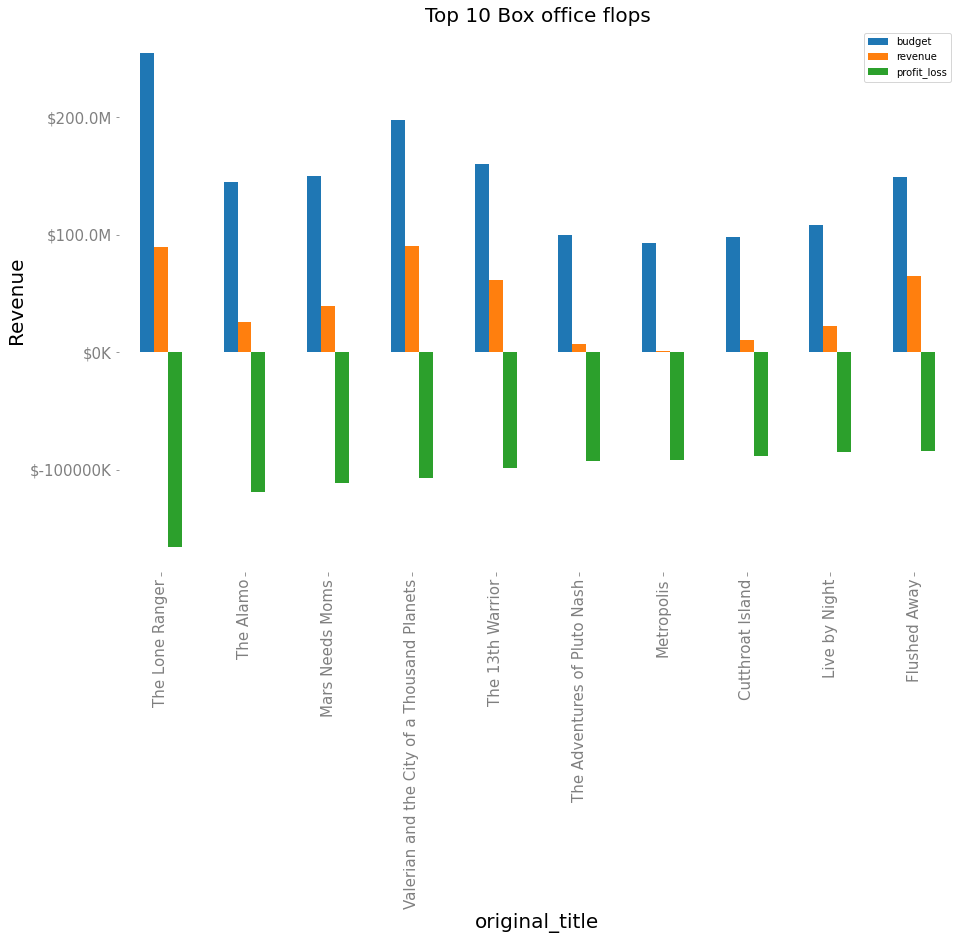

In [33]:
df_moviesByLoss=df.filter(col('revenue')>0)\
                  .withColumn("profit_loss",coalesce(col('revenue'),lit(0))-coalesce(col('budget'),lit(0)))\
                  .filter(col('profit_loss')<0)\
                  .select('id_ori','original_title','revenue','budget',"profit_loss").orderBy(col('profit_loss'),ascending=True)

df_pd_moviesByLoss=df_moviesByLoss.toPandas().head(10)
df_pd_moviesByLoss.to_csv('top_flop_10_movies.csv')

ax=df_pd_moviesByLoss.plot(x="original_title", y=["budget","revenue",'profit_loss'],kind="bar",figsize=(15, 10))
formatter = FuncFormatter(currency)
ax.yaxis.set_major_formatter(formatter)

ax.set_title('Top 10 Box office flops',fontsize=20, loc='center')
ax.set_xlabel('original_title',fontsize=20)
ax.set_ylabel('Revenue',fontsize=20)
plt.legend()
plt.show()

**Movies lauched by year**

In [34]:
df_pd_moviesperYear=df.filter(col('release_date').isNotNull()).select('original_title','release_date',year(to_date(df.release_date,'yyyy-MM-dd')).alias('release_year'))\
                      .groupBy('release_year').count().toPandas()

df_pd_moviesperYear=df_pd_moviesperYear.fillna(0).astype({'release_year':int}).sort_values(by='release_year',ascending=True,inplace=False,ignore_index=True)

df_pd_moviesperYear.to_csv('count_of_moviesperyear.csv')

fig = px.bar(df_pd_moviesperYear, y='count', x='release_year', text='count',title='Number of Succesful Movies launched by year of the 20th Century')
fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')
fig.update_xaxes(
    range=[1900,2018],  # sets the range of xaxis
    constrain="domain",  # meanwhile compresses the xaxis by decreasing its "domain"
)
fig.show()

In [118]:
prod_cntry_schema = ArrayType(StructType([
        StructField('iso_3166_1', StringType(), nullable=False), 
        StructField('name', StringType(), nullable=False)]))


df_prodcntry=df.where(col('production_countries_values')!="").select('id_ori','original_title','production_countries')

df_prodcntry=df_prodcntry.select(*df_prodcntry.columns,explode(from_json(col('production_countries'),prod_cntry_schema)).alias('parsedval'))\
                    .select(*df_prodcntry.columns,col('parsedval').getItem('iso_3166_1').alias('cntry_code'),col('parsedval').getItem('name').alias('cntry_name'))

df_prodcntry=df_prodcntry.where(col('cntry_code')!='Unknown')
df_prodcntry=df_prodcntry.where(col('cntry_name')!='Unknown').show()



+------+--------------------+--------------------+----------+--------------------+
|id_ori|      original_title|production_countries|cntry_code|          cntry_name|
+------+--------------------+--------------------+----------+--------------------+
| 45514|                   8|[{'iso_3166_1': '...|        FR|              France|
| 36337|            Delusion|[{'iso_3166_1': '...|        US|United States of ...|
| 65256|H2O Just Add Wate...|[{'iso_3166_1': '...|        AU|           Australia|
| 75015|Jak rozpętałem dr...|[{'iso_3166_1': '...|        PL|              Poland|
|430514|   Le passe-muraille|[{'iso_3166_1': '...|        FR|              France|
| 88013|      Pauvre Pierrot|[{'iso_3166_1': '...|        FR|              France|
| 16624|    Blacksmith Scene|[{'iso_3166_1': '...|        US|United States of ...|
|105158|Edison Kinetoscop...|[{'iso_3166_1': '...|        US|United States of ...|
|   774|La Sortie de l'Us...|[{'iso_3166_1': '...|        FR|              France|
| 82

**Franchise Movies counts**

In [35]:
df_pd_collection=df.where(col('name').isNotNull()).select(col('name')).groupBy(col('name')).count().orderBy(col('count').desc()).toPandas()
df_pd_collection.head(20)

,name,count
0,The Bowery Boys,29
1,Totò Collection,27
2,James Bond Collection,26
3,Zatôichi: The Blind Swordsman,26
4,The Carry On Collection,25
5,Pokémon Collection,20
6,Godzilla (Showa) Collection,16
7,Charlie Chan (Warner Oland) Collection,15
8,Dragon Ball Z (Movie) Collection,15
9,Monster High Collection,14


In [36]:
genres_schema = ArrayType(StructType([
        StructField('id', StringType(), nullable=False), 
        StructField('name', StringType(), nullable=False)]))

df_wc=df.select(explode(from_json(col('genres'),genres_schema).getField("name").alias('genres_val')))
df_wc.groupby(col('col').alias('gener_values')).count().orderBy(col('count').desc()).show()

+---------------+-----+
|   gener_values|count|
+---------------+-----+
|          Drama|20243|
|         Comedy|13175|
|       Thriller| 7618|
|        Romance| 6730|
|         Action| 6590|
|         Horror| 4670|
|          Crime| 4304|
|    Documentary| 3930|
|      Adventure| 3490|
|Science Fiction| 3042|
|         Family| 2767|
|        Mystery| 2464|
|        Unknown| 2441|
|        Fantasy| 2309|
|      Animation| 1930|
|        Foreign| 1619|
|          Music| 1597|
|        History| 1398|
|            War| 1322|
|        Western| 1042|
+---------------+-----+
only showing top 20 rows



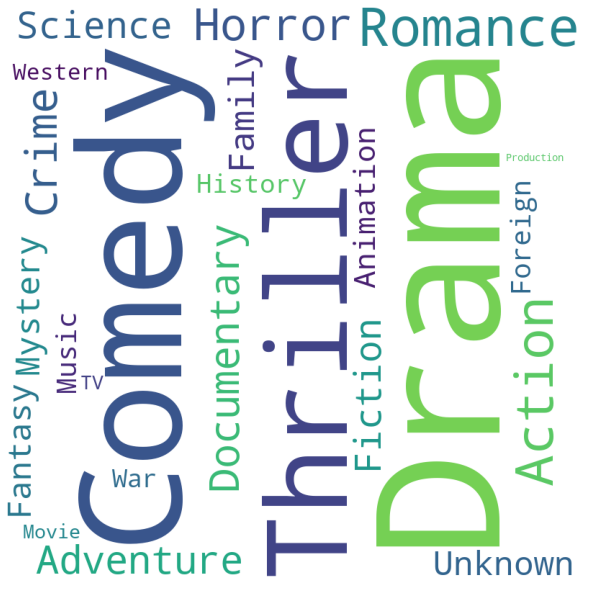

In [37]:
txt=df_wc.agg(concat_ws(',',collect_list(col('col'))).alias('wctxt')).toPandas()

wordcloud = WordCloud(width = 800, height = 800,background_color ='white',min_font_size = 10,collocations=False).generate(txt['wctxt'][0])
wordcloud.words_

# plot the WordCloud image                       
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
  
plt.show()

**Credits.csv - Movie cast & Director**

In [38]:
#Column 'cast' has values in Json string array. Some of key takes value as 'None' for example check movie id - 8844. Below schema definition does not recognize key 
#when it takes value as None. To handle this scenario, I wrote UDF function to replace None to null before parsing Json.


# regexp_extract is used to extract director information from column crew
#(.) - Any character (except newline) - Group 1
#('job': 'Director', 'name': ') - Matches this string - Group 2
#(\w+) - Capture one or more word characters (a-zA-Z0-9_) into group 3
#(\s+) - One or many spaces into Group 3


cast_schema=ArrayType(StructType([
  StructField('cast_id',IntegerType(),nullable=True),
  StructField('character',StringType(),nullable=True),
  StructField('credit_id',StringType(),nullable=True),
  StructField('gender',IntegerType(),nullable=True),
  StructField('id',IntegerType(),nullable=True),
  StructField('name',StringType(),nullable=True),
  StructField('order',IntegerType(),nullable=True),
  StructField('profile_path',StringType(),nullable=True)
]))

def update_cast(value):
    value = value.replace("'profile_path': None", "'profile_path': null")
    return value

convertUDF = udf(lambda z: update_cast(z)) 

credits = credits.withColumn("cast", convertUDF(col("cast")))
credits=credits.withColumn('movies_cast',from_json(col('cast'),cast_schema).getField("name").alias('movies_cast'))\
                .withColumn('director',regexp_extract(col('crew'),"(.)('job': 'Director', 'name': ')((\w+)(\s+)(\w+))(')",3))

credits.show()

+--------------------+--------------------+-----+--------------------+---------------+
|                cast|                crew|   id|         movies_cast|       director|
+--------------------+--------------------+-----+--------------------+---------------+
|[{'cast_id': 14, ...|[{'credit_id': '5...|  862|[Tom Hanks, Tim A...|  John Lasseter|
|[{'cast_id': 1, '...|[{'credit_id': '5...| 8844|[Robin Williams, ...|   Joe Johnston|
|[{'cast_id': 2, '...|[{'credit_id': '5...|15602|[Walter Matthau, ...|  Howard Deutch|
|[{'cast_id': 1, '...|[{'credit_id': '5...|31357|[Whitney Houston,...|Forest Whitaker|
|[{'cast_id': 1, '...|[{'credit_id': '5...|11862|[Steve Martin, Di...|  Charles Shyer|
|[{'cast_id': 25, ...|[{'credit_id': '5...|  949|[Al Pacino, Rober...|   Michael Mann|
|[{'cast_id': 1, '...|[{'credit_id': '5...|11860|[Harrison Ford, J...| Sydney Pollack|
|[{'cast_id': 2, '...|[{'credit_id': '5...|45325|[Jonathan Taylor ...|   Peter Hewitt|
|[{'cast_id': 1, '...|[{'credit_id': '5...|

Director - Genre relation

In [39]:
credits_director=credits.where(col('director')!='').select('id','director')

df2_gener=df.where(col('genres_value')!='').select(col('id_ori'),'genres_value')

df_director=df2_gener.join(credits_director,credits_director.id==df2_gener.id_ori,how='inner').select('id','genres_value','director')

rdd2=df_director.select(col('genres_value')).rdd.flatMap(lambda x:x.genres_value.split(",")).distinct().collect()

exprs=[when(col('genres_value').contains(element),'1').otherwise('0').alias(element) for element in rdd2 ]

df_director=df_director.select(*df_director.columns, *exprs)
df_director.toPandas().to_csv('Director_Genre_Relation.csv')
df_director.show()

+-----+--------------------+---------------+---------+------+------+---------+-------+-------+-----+------+-----+--------+------+-------+---------------+-------+---+-------+-------+-----+-----------+-------+--------+
|   id|        genres_value|       director|Animation|Comedy|Family|Adventure|Fantasy|Romance|Drama|Action|Crime|Thriller|Horror|History|Science Fiction|Mystery|War|Foreign|Unknown|Music|Documentary|Western|TV Movie|
+-----+--------------------+---------------+---------+------+------+---------+-------+-------+-----+------+-----+--------+------+-------+---------------+-------+---+-------+-------+-----+-----------+-------+--------+
|  862|Animation,Comedy,...|  John Lasseter|        1|     1|     1|        0|      0|      0|    0|     0|    0|       0|     0|      0|              0|      0|  0|      0|      0|    0|          0|      0|       0|
| 8844|Adventure,Fantasy...|   Joe Johnston|        0|     0|     1|        1|      1|      0|    0|     0|    0|       0|     0|   

**Movies in which Leonardo Dicaprio worked**

In [40]:
movies=df.where(col('original_title')!='').select(col('id_ori'),'original_title')
actor=credits.withColumn('movies_cast',explode(from_json(col('cast'),cast_schema))).join(movies,movies.id_ori==credits.id,how='inner')\
       .select(col('id'),'original_title',col('director'),col('movies_cast.*'))
decaprio_df=actor.select('original_title','director','character',col('name').alias('actor_name'),'order').where(col('actor_name')=='Leonardo DiCaprio')
decaprio_df.show()
decaprio_df.toPandas().to_csv('decaprio.csv')

+--------------------+-----------------+--------------------+-----------------+-----+
|      original_title|         director|           character|       actor_name|order|
+--------------------+-----------------+--------------------+-----------------+-----+
|The Basketball Di...|    Scott Kalvert|         Jim Carroll|Leonardo DiCaprio|    0|
|       Total Eclipse|Agnieszka Holland|      Arthur Rimbaud|Leonardo DiCaprio|    0|
|The Quick and the...|        Sam Raimi| Fee Herod "The Kid“|Leonardo DiCaprio|    3|
|What's Eating Gil...|                 |         Arnie Grape|Leonardo DiCaprio|    1|
|      Romeo + Juliet|     Baz Luhrmann|               Romeo|Leonardo DiCaprio|    0|
|       Marvin's Room|       Jerry Zaks|                Hank|Leonardo DiCaprio|    2|
|             Titanic|    James Cameron|         Jack Dawson|Leonardo DiCaprio|    1|
|The Man in the Ir...|  Randall Wallace|King Louis XIV / ...|Leonardo DiCaprio|    0|
|           Celebrity|      Woody Allen|             B

**Recommendation system**

Recommender system is defined as recommendation inputs given by the people, which the system then aggregates and directs to appropriate recipients. It can be further defined as a system that produces individualized recommendations as output or has the effect of guiding the user in a personalized way to interesting objects in a larger space of possible options. It is based on below one of the below algorithm.

1. Items Popularity
2. Content based filtering
3. Collaborative based filtering
4. Hybrid filtering

In [41]:
C=(df.agg({'vote_average': 'mean'}).first())[0]
m=(df.filter(col('vote_count').isNotNull()).approxQuantile("vote_count", [0.92], 0))[0]

print('Mean vote across whole report',C)
print('minimum votes required to be listed in the Top 250',m)

Mean vote across whole report 5.6184423703443525
minimum votes required to be listed in the Top 250 228.0


In [86]:
@udf(returnType=StringType())
def weighted_rating(votecnt,voteavg):
    v = votecnt
    R = voteavg
    return (v/(v+m) * R) + (m/(m+v) * C)


df_=df.withColumn('weighted_rating',weighted_rating(col('vote_count').cast('integer'),col('vote_average').cast('integer')))


df_2=df_.select(col('id_ori'),col('original_title'),col('vote_count'),col('vote_average'),col('weighted_rating').cast('integer'))


In [117]:
df_2.show(50)

+------+--------------------+----------+------------+---------------+
|id_ori|      original_title|vote_count|vote_average|weighted_rating|
+------+--------------------+----------+------------+---------------+
| 45514|                   8|         0|         0.0|              5|
| 36337|            Delusion|         3|         4.8|              5|
|161535| Doraemon:貓狗時空傳|         0|         0.0|              5|
| 36663|         Dreamkiller|         1|         5.0|              5|
|118013|           Endeavour|        19|         6.6|              5|
| 65256|H2O Just Add Wate...|        37|         6.4|              5|
| 75015|Jak rozpętałem dr...|         3|         7.0|              5|
|430514|   Le passe-muraille|         0|         0.0|              5|
|293412|        Running Wild|         1|        10.0|              5|
| 88013|      Pauvre Pierrot|        19|         6.1|              5|
| 16624|    Blacksmith Scene|        19|         5.8|              5|
|105158|Edison Kinetoscop

**Collabrative Filtering**

Collaborative filtering uses matrix factorization techniques which allow us to discover the latent features underlying the interactions between users and items.

Matrix factorization , as name suggest, factorize a matrix, i.e. to find out two (or more) matrices such that when you multiply them you will get back the original matrix.In a recommendation system , there is a group of users and a set of items (movies for the above two systems). Given that each users have rated some items in the system, we would like to predict how the users would rate the items that they have not yet rated, such that we can make recommendations to the users. In this case, all the information we have about the existing ratings can be represented in a matrix. Assume now we have 5 users and 10 items, and ratings are integers ranging from 1 to 5, the matrix may look something like this (a hyphen means that the user has not yet rated the movie)


Hence, the task of predicting the missing ratings can be considered as filling in the blanks (the hyphens in the matrix) such that the values would be consistent with the existing ratings in the matrix. The intuition behind using matrix factorization to solve this problem is that there should be some latent features that determine how a user rates an item. For example, two users would give high ratings to a certain movie if they both like the actors or actresses in the movie, or if the movie is an action movie, which is a genre preferred by both users.

In [43]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.sql import Row

ratings.select('userId','movieId','rating','timestamp').show(2)

(training, test) = ratings.randomSplit([0.8, 0.2])

# Build the recommendation model using ALS on the training data
# Note we set cold start strategy to 'drop' to ensure we don't get NaN evaluation metrics

als = ALS(maxIter=5, regParam=0.01, userCol="userId", itemCol="movieId", ratingCol="rating",
          coldStartStrategy="drop")

# numBlocks : Number of blocks the users and items will be partitioned into in order to parallelize computation (defaults to 10).
# rank : Number of latent factors in the model (defaults to 10).
# maxIter : Maximum number of iterations to run (defaults to 10).
# regParam : Specifies the regularization parameter in ALS (defaults to 1.0).
# implicitPrefs : Specifies whether to use the explicit feedback ALS variant or one adapted for implicit feedback data (defaults to false which means using explicit feedback).
# alpha : A parameter applicable to the implicit feedback variant of ALS that governs the baseline confidence in preference observations (defaults to 1.0).

model = als.fit(training)

# Evaluate the model by computing the RMSE on the test data
predictions = model.transform(test)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",predictionCol="prediction")
rmse = evaluator.evaluate(predictions)

print("Root-mean-square error = " + str(rmse))


+------+-------+------+----------+
|userId|movieId|rating| timestamp|
+------+-------+------+----------+
|     1|    110|   1.0|1425941529|
|     1|    147|   4.5|1425942435|
+------+-------+------+----------+
only showing top 2 rows

Root-mean-square error = 0.8427294368929218


In [44]:
predictions = model.transform(test)
predictions.show()

+------+-------+------+----------+----------+
|userId|movieId|rating| timestamp|prediction|
+------+-------+------+----------+----------+
|     1|    858|   5.0|1425941523| 3.8003142|
|     1|   1968|   4.0|1425942148|  4.278361|
|     1|   2959|   4.0|1425941601| 3.9857569|
|     1|  58559|   4.0|1425942007| 3.2480447|
|     1|  68358|   5.0|1425941464| 4.3612947|
|     1|  81834|   5.0|1425942133|  3.991836|
|     3|    480|   3.0|1048076925| 2.3813317|
|     3|    500|   2.0|1048076945|   2.80454|
|     3|    858|   4.0|1048076945| 3.1148357|
|     3|   1092|   3.0|1048076995| 2.4994407|
|     3|   1097|   3.0|1048076961| 3.4787796|
|     3|   1270|   3.0|1048076976| 2.3926623|
|     5|    296|   4.0| 949424343|  4.633818|
|     5|    750|   5.0| 949424271| 4.2855372|
|     5|    908|   5.0| 949424374|  4.400548|
|     5|   1225|   4.0| 949424343| 5.3065305|
|     5|   2163|   2.0| 949424522|-0.4679759|
|     5|   3079|   5.0| 949423938| 4.1425123|
|     6|     11|   3.0| 944894480|

In [109]:
%%time
# Generate top 5 movie recommendations for each user
userRecs = model.recommendForAllUsers(5)

# Generate top 5 user recommendations for each movie
movieRecs = model.recommendForAllItems(5)

CPU times: user 23.9 ms, sys: 708 µs, total: 24.7 ms
Wall time: 1.67 s


In [115]:
userRecs_df = userRecs.toPandas()
movieRecs_df = movieRecs.toPandas()

In [116]:
# converting Spark dataframe to Python data frame

print(userRecs_df.shape)
userRecs_df.to_csv('User_Recommendation_to_Movies.csv')

movieRecs_df = movieRecs.toPandas()
print(movieRecs_df.shape)

movieRecs_df.to_csv('Movie_Recommendation_to_Users.csv')

(269728, 2)
(43390, 2)
